
# **Classification**

Making accurate predictions about binary outcomes—such as determining whether a signal was received in a communication network—is a common task in engineering workflows. Using a Bernoulli likelihood, Gaussian Processes (GPs) in `twinLab` offer a powerful and flexible approach to tackling binary classification problems. This combination allows us to capture the underlying probability of an unseen data point belonging to a particular class, enabling reliable, trustworthy, and robust decision-making in engineering applications.

This notebook will cover how to:

1. [Generate data suitable for classification.](#1.-Generate-data-suitable-for-classification)
2. [Upload a dataset and train a classification emulator.](#2.-Upload-dataset-and-train-your-emulator)
3. [Predict the class probability of unseen data using a classification emulator.](#3.-Predict-using-a-classification-emulator)
4. [Visualise the results of the prediction of a classification emulator.](#4.-Viewing-the-results)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.10.0
          User        : alexander@digilab.co.uk
          Server      : http://localhost:8000
          Environment : /Users/mead/digiLab/twinLab/tutorials/.env



Make sure you set up your API key and other information to be able to use `twinLab`, either through a `.env` file, using secrets, or via `tl.set_user` and `tl.set_api_key`.

### **1. Generate data suitable for classification**

You can use the following code to simulate a dataset that can be used to train a classification GP. Here, the output classes ('y') are either 0 or 1. 

In [2]:
np.random.seed(123)
n = 25
R = 0.8
X = np.random.uniform(-1, 1, (n, 2))
y = 0.5 * (np.sign(R**2 - (X[:, 0] ** 2 + X[:, 1] ** 2)) + 1.0)

`twinLab` expects data in the form of a `pandas DataFrame`, so we need to take the data we've generated and convert it to this form. 

In [3]:
X = pd.DataFrame(X, columns=["X1", "X2"])
y = pd.Series(y, name="y")
df = pd.concat([X, y], axis="columns")

Check that the DataFrame looks like you expect it: 

In [4]:
df.head()

,X1,X2,y
0,0.392938,-0.427721,1.0
1,-0.546297,0.102630,1.0
2,0.438938,-0.153787,1.0
3,0.961528,0.369659,0.0
4,-0.038136,-0.215765,1.0


To have a better look of the generated data, you can plot it using the following block of code:

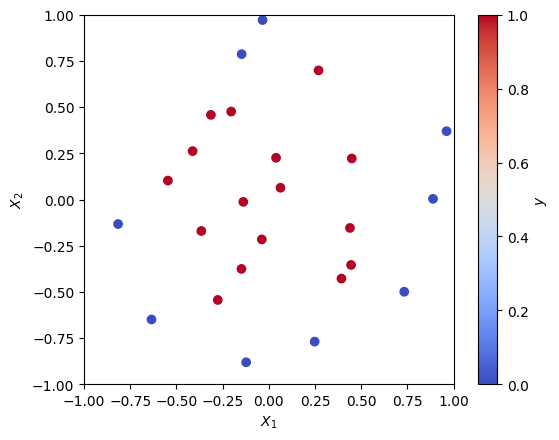

In [5]:
plt.scatter(df["X1"], df["X2"], c=df["y"], cmap="coolwarm")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.gca().set_aspect("equal", adjustable="box")
plt.colorbar(label=r"$y$")
plt.show()

Now, you can train a classification `twinLab` model that identifies the patterns underlying the data and approximates the true function that you established in section one (represented by the red dotted line you generated in the plot).

### **2. Upload dataset and train your emulator**

To start training, you will have to specify the type of GP ("classification_gp") inside `tl.EstimatorParams`. 

The rest of the process is the same as the one you would follow to train a standard `twinLab` model, with the one caveat that the output (*y*) takes a binary value. 

Create a `Dataset` with an `id` which is used to access it. Using the `upload` method, you can then upload the `Dataset` to your `twinLab` cloud account.

In [6]:
dataset = tl.Dataset(id="classification")
dataset.upload(df)

Use the `twinLab` `Emulator` class to define an emulator with an `id`, under which your emulator will be saved as in the `twinLab` cloud.

In [7]:
emulator = tl.Emulator(id="classification")

When you want to train a model, you pass on your training requirements via arguments using a `TrainParams` object. `TrainParams` is a class that contains all the necessary parameters needed to train your model

In [8]:
estimator_params = tl.EstimatorParams(
    estimator_type="classification_gp"
)  # Specify the "classification_gp" estimator
params = tl.TrainParams(estimator_params=estimator_params)
emulator.train(dataset, inputs=["X1", "X2"], outputs=["y"], params=params)

Emulator 'classification' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: success
Training of emulator classification is complete!


### **3. Predict using a trained classifier**

Now, you can use the trained emulator to classify new incoming data. First you need to generate data to use in evaluating our trained emulator: 

In [9]:
N = 5
X1 = np.linspace(-1, 1, N)
X2 = np.zeros(N)
df_X = pd.DataFrame({"X1": X1, "X2": X2})

Then, the process of running `predict` is exactly the same as the one you would follow for a standard `twinlab` emulator.

In [10]:
pred, prob = emulator.predict(df_X, verbose=False)

Let's view our data:

In [11]:
df_results = pd.concat([df_X, pred, prob], axis="columns")
df_results.columns = ["X1", "X2", "y (pred)", "y (prob)"]
df_results.head()

,X1,X2,y (pred),y (prob)
0,-1.0,0.0,0.0,0.229462
1,-0.5,0.0,1.0,0.863353
2,0.0,0.0,1.0,0.988727
3,0.5,0.0,1.0,0.870965
4,1.0,0.0,0.0,0.095155


Note some important differences between the values here compared to those from a regression model: 

First, the training data contains only binary values for `y` of either 0 or 1, here the value of `y` is also either 0 or 1. This is the prediction for the class that `X` belongs to. The second column is the probability that the emulator has assigned to the class membership. Values close to indicate that the model has a high degree of certainty that the `X` belongs to class 0; values close to 1 indicate a high degree of certainty that it belongs to class 1.

### **4. Viewing the results**

You can create a heatmap of predictions to better visualise the classification boundaries in 2D. You can also plot the training data over the heatmap, to see how the training data combine to create the prediction.

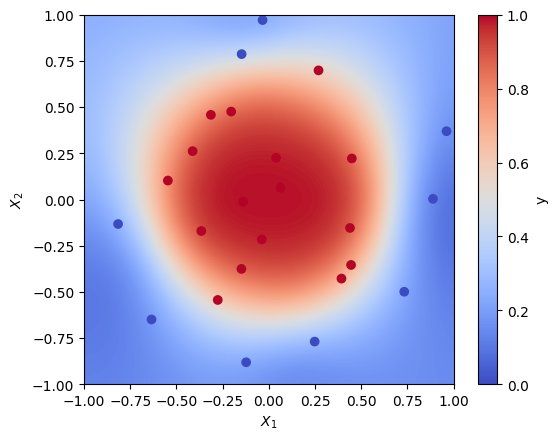

In [12]:
plt = emulator.heatmap(
    "X1",
    "X2",
    "y",
    mean_or_std="std",
    x1_lim=(-1, 1),
    x2_lim=(-1, 1),
    y_lim=(0, 1),
    cmap="coolwarm",
)
plt.scatter(df["X1"], df["X2"], c=df["y"], cmap="coolwarm")
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.show()

### **Deleting datasets and emulators**

Finally, you can delete your datasets and emulators to keep your twinLab cloud account storage tidy. 

Please be aware that this is permanent. Always consider keeping your data locally backed up.

In [13]:
# Delete emulator and dataset
emulator.delete()
dataset.delete()